# Install Dependencies

In [ ]:
!pip install torch-optimizer
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 1.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manyli

In [ ]:
from glob import glob

import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.preprocessing import LabelEncoder

import torch
import torchvision
from torch import Tensor
from torchvision import transforms
from torchvision import datasets, models
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torch.utils.data import Dataset
from torch.utils.data import DataLoader


import torch_optimizer as optim
import albumentations as A

import timm
import sklearn
from tqdm import tqdm

import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Retrieval

In [ ]:
!unzip /content/drive/MyDrive/cs444-final-project/project/data/small_data/train.zip

In [ ]:
!unzip /content/drive/MyDrive/cs444-final-project/project/data/small_data/test.zip


# Hyperparamters

In [ ]:
NUM_WORKERS = 2
BATCH_SIZE = 16
MODEL_SAVE_TO = '/content/drive/MyDrive/cs444-final-project/project/models/baselines/saved_models/swin_ep=30_best_model.pth'
NUM_EPOCHS = 30
LOG_FREQ = 10
NUM_CLASSES = 25
BETAS = (0.9,0.999)
EPS = 1e-3
WEIGHT_DECAY = 1e-4
LR = 1e-3
LOG_FILE = '/content/drive/MyDrive/cs444-final-project/project/models/baselines/train_logs/swin_ep=30_best_model.log'
os.makedirs("/content/drive/MyDrive/cs444-final-project/project/models/baselines/train_logs/", exist_ok=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dataset and Dataloader

In [ ]:
class LandmarkImageDataset(Dataset):
    def __init__(self, annotations_file, transform=None, id_path_mapping="", is_pt=False):
        """
        Args:
            annotations_file (string): Path to the CSV file with annotations.
            img_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
            file_extension (string, optional): Extension of the image files in the directory.
        """
        self.img_labels = pd.read_csv(annotations_file)
        self.id_to_label = {str(row[0]): row[3] for row in self.img_labels.values}
        self.transform = transform
        self.id_path_mapping = pd.read_csv(id_path_mapping)
        self.length = len(self.id_path_mapping)
        self.is_pt = is_pt


    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        # Retrieve the image ID and path from the mapping
        image_id = self.id_path_mapping.iloc[idx]['id']
        image_path = self.id_path_mapping.iloc[idx]['path']

        label = self.id_to_label[str(image_id)]

        if self.is_pt:
            tensor = torch.load(image_path)
            if self.transform:
                tensor = self.transform(tensor)
            return tensor, label
        else:
            # Load the image
            image = Image.open(image_path).convert('RGB')
            # Apply transform if any
            if self.transform:
                image = self.transform(image)
            return image, label


# Define transformations for the training data
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_transform_pt = transforms.Compose([
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

label_csv = "/content/drive/MyDrive/cs444-final-project/project/data/small_data/small_data.csv"
train_img_id_to_path_mapping = "/content/drive/MyDrive/cs444-final-project/project/data/small_data/train_img_id_to_path_mapping_drive.csv"
# Create an instance of the dataset
train_dataset = LandmarkImageDataset(
    annotations_file=label_csv,
    transform=train_transform,
    id_path_mapping=train_img_id_to_path_mapping,
    # is_pt=Trued
    is_pt=False
)

# Define the DataLoader
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)




In [ ]:
len(train_dataset)

6731

# Optimzer

In [ ]:
def radam(parameters, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0):
    if isinstance(betas, str):
        betas = eval(betas)
    return optim.RAdam(parameters, lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)

# Evaluation Metrics

In [ ]:
class RunningAverage:
    '''
      Computes and keeps track of the running average and the current value of metrics
    '''
    def __init__(self) -> None:
        self.val = 0.0
        self.avg = 0.0
        self.sum = 0.0
        self.count = 0

    def update(self, val: float, n: int = 1) -> None:
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def GAP(predicts: torch.Tensor, confs: torch.Tensor, targets: torch.Tensor) -> float:
    """
    Calculates the simplified Global Average Precision.
    https://www.kaggle.com/competitions/landmark-recognition-2020/overview/evaluation

    Args:
        predicts (torch.Tensor): Predicted labels of shape (n_samples,).
        confs (torch.Tensor): Confidence scores associated with predictions, of shape (n_samples,).
        targets (torch.Tensor): Ground truth labels, of shape (n_samples,).

    Returns:
        float: The GAP score for the given predictions and targets.
    """
    assert len(predicts.shape) == 1 and len(confs.shape) == 1 and len(targets.shape) == 1 and predicts.shape == confs.shape and confs.shape == targets.shape

    _, indices = torch.sort(confs, descending=True)

    confs = confs.cpu().numpy()
    predicts = predicts[indices].cpu().numpy()
    targets = targets[indices].cpu().numpy()

    res, true_pos = 0.0, 0

    for i, (c, p, t) in enumerate(zip(confs, predicts, targets)):
        rel = int(p == t)
        true_pos += rel

        res += true_pos / (i + 1) * rel

    res /= targets.shape[0]
    return res

# Model Initialization

In [ ]:
model = timm.create_model('swin_tiny_patch4_window7_224', pretrained=True, num_classes=NUM_CLASSES)

# Model Finetuning

In [ ]:
def train(train_loader, model, criterion, optimizer, lr_scheduler, epochs=10):
    train_losses = []
    train_gap = []
    train_accuracies = []
    best_score = float('-inf')
    for epoch in range(epochs):
        losses = RunningAverage()
        avg_score = RunningAverage()
        avg_accuracy = RunningAverage()

        model.train()
        num_batches = len(train_loader)

        lr = None
        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}', leave=True)
        for i, (inputs, labels) in enumerate(progress_bar):
            inputs, labels = inputs.to(device), labels.to(device)
            output = model(inputs)

            # target = torch.argmax(target, dim=1)
            # print(output.shape)
            loss = criterion(output, labels)
            confs, predicts = torch.max(output.detach(), dim=1)

            # Calculate accuracy
            correct = predicts.eq(labels).sum().item()
            total = labels.size(0)
            accuracy = 100 * correct / total
            avg_accuracy.update(accuracy, total)


            avg_score.update(GAP(predicts, confs, labels))
            losses.update(loss.data.item(), inputs.size(0))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            lr_scheduler.step()
            lr = optimizer.param_groups[0]['lr']

            # Update tqdm progress bar description with status
            if i % LOG_FREQ == 0 or i == num_batches - 1:
                progress_desc = (
                    f'Epoch {epoch + 1}/{epochs} - '
                    f'Batch {i + 1}/{num_batches} - '
                    f'Loss: {losses.val:.4f} (Avg: {losses.avg:.4f}) - '
                    f'GAP score: {avg_score.val:.4f} (Avg: {avg_score.avg:.4f}) - '
                    f'Accuracy: {avg_accuracy.val:.2f}% (Avg: {avg_accuracy.avg:.2f}%) - '
                    f'LR: {lr:.6f}'
                )
                progress_bar.set_description(progress_desc)
                progress_bar.refresh()  # to show immediate updates

        # Checkpoint
        if avg_score.avg > best_score:
            best_score = avg_score.avg
            torch.save(model.state_dict(), MODEL_SAVE_TO)
            print(f'Saved new best model with avg GAP: {best_score:.4f}')

        train_gap.append(avg_score.avg)
        train_losses.append(losses.avg)
        train_accuracies.append(avg_accuracy.avg)

        # Clear the last progress description to avoid redundancy with the next epoch
        progress_bar.set_description(f'Epoch {epoch+1}/{epochs}')
        progress_bar.refresh()
        print(f'      ==== GAP score in epoch {epoch + 1}: {avg_score.avg:.4f} ===')

    return train_losses, train_gap, train_accuracies

In [ ]:

criterion = nn.CrossEntropyLoss()
optimizer = radam(model.parameters(), lr=LR, betas=BETAS, eps=EPS, weight_decay=WEIGHT_DECAY)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=len(train_loader) * NUM_EPOCHS, eta_min=1e-6)
model.to(device)

train_losses, train_gap, train_accuracies = train(train_loader, model, criterion, optimizer, scheduler, NUM_EPOCHS)

Epoch 1/30 - Batch 421/421 - Loss: 0.9423 (Avg: 1.4045) - GAP score: 0.6298 (Avg: 0.5419) - Accuracy: 72.73% (Avg: 59.74%) - LR: 0.000997: 100%|██████████| 421/421 [00:29<00:00, 14.17it/s]


Saved new best model with avg GAP: 0.5419
      ==== GAP score in epoch 1: 0.5419 ===


Epoch 2/30 - Batch 421/421 - Loss: 0.7231 (Avg: 0.9924) - GAP score: 0.7172 (Avg: 0.6494) - Accuracy: 72.73% (Avg: 69.59%) - LR: 0.000989: 100%|██████████| 421/421 [00:28<00:00, 14.92it/s]


Saved new best model with avg GAP: 0.6494
      ==== GAP score in epoch 2: 0.6494 ===


Epoch 3/30 - Batch 421/421 - Loss: 0.7049 (Avg: 0.9932) - GAP score: 0.6595 (Avg: 0.6562) - Accuracy: 72.73% (Avg: 70.27%) - LR: 0.000976: 100%|██████████| 421/421 [00:28<00:00, 14.72it/s]


Saved new best model with avg GAP: 0.6562
      ==== GAP score in epoch 3: 0.6562 ===


Epoch 4/30 - Batch 421/421 - Loss: 0.7697 (Avg: 1.0244) - GAP score: 0.8182 (Avg: 0.6462) - Accuracy: 81.82% (Avg: 69.37%) - LR: 0.000957: 100%|██████████| 421/421 [00:28<00:00, 14.96it/s]


      ==== GAP score in epoch 4: 0.6462 ===


Epoch 5/30 - Batch 421/421 - Loss: 0.2204 (Avg: 1.0212) - GAP score: 0.9091 (Avg: 0.6399) - Accuracy: 90.91% (Avg: 68.76%) - LR: 0.000933: 100%|██████████| 421/421 [00:28<00:00, 14.83it/s]


      ==== GAP score in epoch 5: 0.6399 ===


Epoch 6/30 - Batch 421/421 - Loss: 0.3673 (Avg: 0.9044) - GAP score: 0.9091 (Avg: 0.6826) - Accuracy: 90.91% (Avg: 72.49%) - LR: 0.000905: 100%|██████████| 421/421 [00:28<00:00, 14.88it/s]


Saved new best model with avg GAP: 0.6826
      ==== GAP score in epoch 6: 0.6826 ===


Epoch 7/30 - Batch 421/421 - Loss: 0.5521 (Avg: 0.9989) - GAP score: 0.8703 (Avg: 0.6497) - Accuracy: 90.91% (Avg: 69.57%) - LR: 0.000872: 100%|██████████| 421/421 [00:28<00:00, 14.85it/s]


      ==== GAP score in epoch 7: 0.6497 ===


Epoch 8/30 - Batch 421/421 - Loss: 0.9783 (Avg: 0.7888) - GAP score: 0.7172 (Avg: 0.7222) - Accuracy: 72.73% (Avg: 76.01%) - LR: 0.000835: 100%|██████████| 421/421 [00:28<00:00, 14.92it/s]


Saved new best model with avg GAP: 0.7222
      ==== GAP score in epoch 8: 0.7222 ===


Epoch 9/30 - Batch 421/421 - Loss: 0.6630 (Avg: 0.7215) - GAP score: 0.6541 (Avg: 0.7400) - Accuracy: 72.73% (Avg: 77.36%) - LR: 0.000794: 100%|██████████| 421/421 [00:28<00:00, 14.96it/s]


Saved new best model with avg GAP: 0.7400
      ==== GAP score in epoch 9: 0.7400 ===


Epoch 10/30 - Batch 421/421 - Loss: 0.1486 (Avg: 0.6280) - GAP score: 1.0000 (Avg: 0.7737) - Accuracy: 100.00% (Avg: 80.23%) - LR: 0.000750: 100%|██████████| 421/421 [00:28<00:00, 14.94it/s]


Saved new best model with avg GAP: 0.7737
      ==== GAP score in epoch 10: 0.7737 ===


Epoch 11/30 - Batch 421/421 - Loss: 0.2673 (Avg: 0.5498) - GAP score: 0.9091 (Avg: 0.7992) - Accuracy: 90.91% (Avg: 82.47%) - LR: 0.000704: 100%|██████████| 421/421 [00:28<00:00, 14.95it/s]


Saved new best model with avg GAP: 0.7992
      ==== GAP score in epoch 11: 0.7992 ===


Epoch 12/30 - Batch 421/421 - Loss: 0.6658 (Avg: 0.4816) - GAP score: 0.6033 (Avg: 0.8241) - Accuracy: 63.64% (Avg: 84.59%) - LR: 0.000655: 100%|██████████| 421/421 [00:28<00:00, 14.99it/s]


Saved new best model with avg GAP: 0.8241
      ==== GAP score in epoch 12: 0.8241 ===


Epoch 13/30 - Batch 421/421 - Loss: 0.4571 (Avg: 0.4062) - GAP score: 0.7835 (Avg: 0.8541) - Accuracy: 81.82% (Avg: 87.13%) - LR: 0.000604: 100%|██████████| 421/421 [00:28<00:00, 14.86it/s]


Saved new best model with avg GAP: 0.8541
      ==== GAP score in epoch 13: 0.8541 ===


Epoch 14/30 - Batch 421/421 - Loss: 0.5979 (Avg: 0.3619) - GAP score: 0.8182 (Avg: 0.8641) - Accuracy: 81.82% (Avg: 87.89%) - LR: 0.000553: 100%|██████████| 421/421 [00:28<00:00, 15.02it/s]


Saved new best model with avg GAP: 0.8641
      ==== GAP score in epoch 14: 0.8641 ===


Epoch 15/30 - Batch 421/421 - Loss: 0.5587 (Avg: 0.3692) - GAP score: 0.6759 (Avg: 0.8628) - Accuracy: 72.73% (Avg: 87.88%) - LR: 0.000500: 100%|██████████| 421/421 [00:28<00:00, 14.89it/s]


      ==== GAP score in epoch 15: 0.8628 ===


Epoch 16/30 - Batch 421/421 - Loss: 0.0831 (Avg: 0.2449) - GAP score: 1.0000 (Avg: 0.9090) - Accuracy: 100.00% (Avg: 91.90%) - LR: 0.000448: 100%|██████████| 421/421 [00:28<00:00, 15.00it/s]


Saved new best model with avg GAP: 0.9090
      ==== GAP score in epoch 16: 0.9090 ===


Epoch 17/30 - Batch 421/421 - Loss: 0.0100 (Avg: 0.1747) - GAP score: 1.0000 (Avg: 0.9349) - Accuracy: 100.00% (Avg: 94.16%) - LR: 0.000397: 100%|██████████| 421/421 [00:28<00:00, 14.80it/s]


Saved new best model with avg GAP: 0.9349
      ==== GAP score in epoch 17: 0.9349 ===


Epoch 18/30 - Batch 421/421 - Loss: 0.2460 (Avg: 0.1400) - GAP score: 0.9091 (Avg: 0.9492) - Accuracy: 90.91% (Avg: 95.32%) - LR: 0.000346: 100%|██████████| 421/421 [00:28<00:00, 14.92it/s]


Saved new best model with avg GAP: 0.9492
      ==== GAP score in epoch 18: 0.9492 ===


Epoch 19/30 - Batch 421/421 - Loss: 0.0335 (Avg: 0.0997) - GAP score: 1.0000 (Avg: 0.9641) - Accuracy: 100.00% (Avg: 96.69%) - LR: 0.000297: 100%|██████████| 421/421 [00:28<00:00, 14.81it/s]


Saved new best model with avg GAP: 0.9641
      ==== GAP score in epoch 19: 0.9641 ===


Epoch 20/30 - Batch 421/421 - Loss: 0.0339 (Avg: 0.0599) - GAP score: 1.0000 (Avg: 0.9783) - Accuracy: 100.00% (Avg: 97.99%) - LR: 0.000251: 100%|██████████| 421/421 [00:28<00:00, 14.95it/s]


Saved new best model with avg GAP: 0.9783
      ==== GAP score in epoch 20: 0.9783 ===


Epoch 21/30 - Batch 421/421 - Loss: 0.0012 (Avg: 0.0518) - GAP score: 1.0000 (Avg: 0.9802) - Accuracy: 100.00% (Avg: 98.17%) - LR: 0.000207: 100%|██████████| 421/421 [00:28<00:00, 14.54it/s]


Saved new best model with avg GAP: 0.9802
      ==== GAP score in epoch 21: 0.9802 ===


Epoch 22/30 - Batch 421/421 - Loss: 0.0006 (Avg: 0.0299) - GAP score: 1.0000 (Avg: 0.9894) - Accuracy: 100.00% (Avg: 98.99%) - LR: 0.000166: 100%|██████████| 421/421 [00:28<00:00, 14.86it/s]


Saved new best model with avg GAP: 0.9894
      ==== GAP score in epoch 22: 0.9894 ===


Epoch 23/30 - Batch 421/421 - Loss: 0.0014 (Avg: 0.0259) - GAP score: 1.0000 (Avg: 0.9922) - Accuracy: 100.00% (Avg: 99.27%) - LR: 0.000129: 100%|██████████| 421/421 [00:28<00:00, 14.84it/s]


Saved new best model with avg GAP: 0.9922
      ==== GAP score in epoch 23: 0.9922 ===


Epoch 24/30 - Batch 421/421 - Loss: 0.0000 (Avg: 0.0196) - GAP score: 1.0000 (Avg: 0.9944) - Accuracy: 100.00% (Avg: 99.47%) - LR: 0.000096: 100%|██████████| 421/421 [00:28<00:00, 14.98it/s]


Saved new best model with avg GAP: 0.9944
      ==== GAP score in epoch 24: 0.9944 ===


Epoch 25/30 - Batch 421/421 - Loss: 0.0003 (Avg: 0.0116) - GAP score: 1.0000 (Avg: 0.9968) - Accuracy: 100.00% (Avg: 99.69%) - LR: 0.000068: 100%|██████████| 421/421 [00:28<00:00, 14.81it/s]


Saved new best model with avg GAP: 0.9968
      ==== GAP score in epoch 25: 0.9968 ===


Epoch 26/30 - Batch 421/421 - Loss: 0.0004 (Avg: 0.0092) - GAP score: 1.0000 (Avg: 0.9975) - Accuracy: 100.00% (Avg: 99.76%) - LR: 0.000044: 100%|██████████| 421/421 [00:28<00:00, 14.89it/s]


Saved new best model with avg GAP: 0.9975
      ==== GAP score in epoch 26: 0.9975 ===


Epoch 27/30 - Batch 421/421 - Loss: 0.0000 (Avg: 0.0111) - GAP score: 1.0000 (Avg: 0.9973) - Accuracy: 100.00% (Avg: 99.73%) - LR: 0.000025: 100%|██████████| 421/421 [00:28<00:00, 14.95it/s]


      ==== GAP score in epoch 27: 0.9973 ===


Epoch 28/30 - Batch 421/421 - Loss: 0.0003 (Avg: 0.0077) - GAP score: 1.0000 (Avg: 0.9980) - Accuracy: 100.00% (Avg: 99.81%) - LR: 0.000012: 100%|██████████| 421/421 [00:28<00:00, 14.91it/s]


Saved new best model with avg GAP: 0.9980
      ==== GAP score in epoch 28: 0.9980 ===


Epoch 29/30 - Batch 421/421 - Loss: 0.0002 (Avg: 0.0075) - GAP score: 1.0000 (Avg: 0.9979) - Accuracy: 100.00% (Avg: 99.81%) - LR: 0.000004: 100%|██████████| 421/421 [00:28<00:00, 14.91it/s]


      ==== GAP score in epoch 29: 0.9979 ===


Epoch 30/30 - Batch 421/421 - Loss: 0.0002 (Avg: 0.0085) - GAP score: 1.0000 (Avg: 0.9971) - Accuracy: 100.00% (Avg: 99.72%) - LR: 0.000001: 100%|██████████| 421/421 [00:28<00:00, 14.92it/s]

      ==== GAP score in epoch 30: 0.9971 ===


In [ ]:
import matplotlib.pyplot as plt

def plot_metrics(train_losses, train_accuracies):
    plt.figure(figsize=(10, 5))

    # First y-axis for the training loss
    ax1 = plt.gca()
    line1, = ax1.plot(train_losses, label='Training Loss', color='red', marker='o')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss', color='red')
    ax1.tick_params(axis='y', labelcolor='red')

    # Second y-axis for the training accuracy
    ax2 = ax1.twinx()
    line2, = ax2.plot(train_accuracies, label='Training GAP Score', color='blue', marker='x')
    ax2.set_ylabel('Accuracy / GAP', color='blue')
    ax2.tick_params(axis='y', labelcolor='blue')

    plt.title('Training Loss and Accuracy')
    ax1.grid(True)
    lines = [line1, line2]
    labels = [l.get_label() for l in lines]
    plt.legend(lines, labels, loc='center right')

    plt.show()



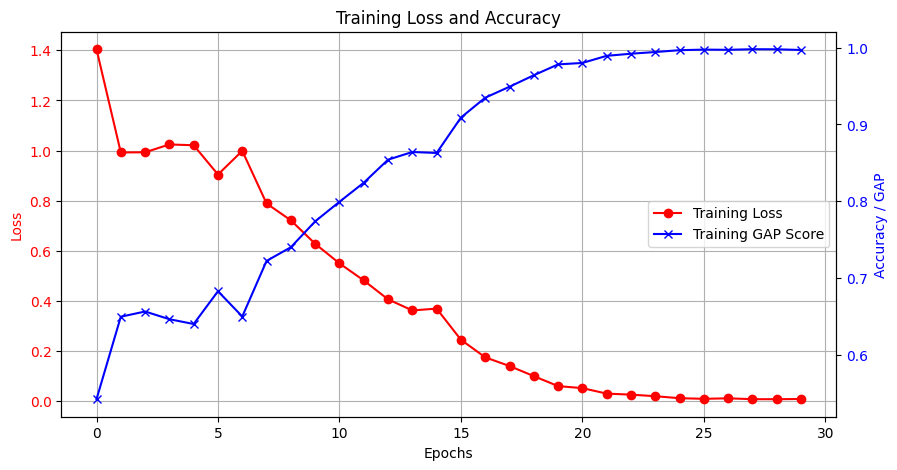

maximum GAP score achieved with 99.8042% at epoch 28


In [ ]:
# Plot losses
import numpy as np
# acc = [acc.item() for acc in train_accuracies]
plot_metrics(train_losses, train_gap)
print(f"maximum GAP score achieved with {round(max(train_gap), 6) * 100}% at epoch {np.argmax(train_gap) + 1}")

In [ ]:
MODEL_SAVE_TO

'/content/drive/MyDrive/cs444-final-project/project/models/baselines/saved_models/swin_ep=30_best_model.pth'

In [ ]:
# prompt: I want to save the three lists train_losses, train_gap, train_accuracies into a json file called "vit_base_224_ep=30.json"

import json

data = {
    "train_loss": train_losses,
    "train_accuracy": train_accuracies,
    "train_gap": train_gap
}

with open(LOG_FILE, "w") as json_file:
    json.dump(data, json_file, indent=4)


# Test and Eavluation

In [ ]:
def evaluate_model(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0  # Track total samples processed

    with torch.no_grad():
        progress_bar = tqdm(enumerate(dataloader), total=len(dataloader), desc="Evaluating", leave=True)
        for i, (inputs, labels) in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_predictions += torch.sum(preds == labels.data)
            total_samples += labels.size(0)

            # Update the progress bar with average loss and accuracy
            average_loss = running_loss / total_samples
            average_accuracy = correct_predictions.double() / total_samples
            progress_bar.set_postfix({'avg_loss': f'{average_loss:.4f}', 'avg_acc': f'{average_accuracy:.2f}'})

    total_loss = running_loss / len(dataloader)
    accuracy = correct_predictions.double() / len(dataloader.dataset)
    # print(f'Validation Loss: {total_loss}, Accuracy: {accuracy}')
    return total_loss, accuracy  # Optionally return metrics for further analysis


In [ ]:
# Define transformations for the training data
test_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


label_csv = "/content/drive/MyDrive/cs444-final-project/project/data/small_data/small_data.csv"
test_img_id_to_path_mapping = "/content/drive/MyDrive/cs444-final-project/project/data/small_data/test_img_id_to_path_mapping_drive.csv"
# Create an instance of the dataset
test_dataset = LandmarkImageDataset(
    annotations_file=label_csv,
    transform=train_transform,
    id_path_mapping=test_img_id_to_path_mapping
)

# Define the DataLoader
test_loader = DataLoader(dataset=test_dataset, batch_size=16, shuffle=False, num_workers=NUM_WORKERS)

model.to(device)
model.load_state_dict(torch.load(MODEL_SAVE_TO))

# Evaluate the model
test_loss, test_accuracy = evaluate_model(model, test_loader, criterion, device)
print(f"\nTest Loss: {test_loss}, Test Accuracy: {test_accuracy}")


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Evaluating: 100%|██████████| 46/46 [00:03<00:00, 14.64it/s, avg_loss=0.0794, avg_acc=0.81]



Test Loss: 1.2679022165096325, Test Accuracy: 0.8136054421768707


# More experiments

In [ ]:
LOG_FILE = '/content/drive/MyDrive/cs444-final-project/project/models/baselines/train_logs/ablation_swin_transformer.log'
MODEL_SAVE_TO = '/content/drive/MyDrive/cs444-final-project/project/models/baselines/saved_models/ablation_swin_transformer.pth'

In [ ]:
from tqdm import tqdm
def train_and_evaluate_model(
    model, train_loader, test_loader, loss_fn, optimizer, lr_scheduler, device, epochs=10, model_save_path="best_model.pth"
):
    model.to(device)
    train_losses = []
    train_accuracies = []
    train_gap = []
    test_accuracies = []
    best_test_accuracy = float("-inf")

    for epoch in range(epochs):
        model.train()
        num_batches = len(train_loader)

        losses = RunningAverage()
        avg_score = RunningAverage()
        avg_accuracy = RunningAverage()

        running_loss = 0.0
        correct_predictions = 0
        total_samples = 0

        # Training loop with progress bar
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=True)
        for i, (inputs, labels) in enumerate(progress_bar):
            inputs, labels = inputs.to(device), labels.to(device)
            output = model(inputs)
            loss = criterion(output, labels)
            confs, predicts = torch.max(output.detach(), dim=1)

            # Calculate accuracy
            correct = predicts.eq(labels).sum().item()
            total = labels.size(0)
            accuracy = 100 * correct / total
            avg_accuracy.update(accuracy, total)


            avg_score.update(GAP(predicts, confs, labels))
            losses.update(loss.data.item(), inputs.size(0))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            lr_scheduler.step()
            lr = optimizer.param_groups[0]['lr']

            # Update tqdm progress bar description with status
            if i % LOG_FREQ == 0 or i == num_batches - 1:
                progress_desc = (
                    f'Epoch {epoch + 1}/{epochs} - '
                    f'Batch {i + 1}/{num_batches} - '
                    f'Loss: {losses.val:.4f} (Avg: {losses.avg:.4f}) - '
                    f'GAP score: {avg_score.val:.4f} (Avg: {avg_score.avg:.4f}) - '
                    f'Accuracy: {avg_accuracy.val:.2f}% (Avg: {avg_accuracy.avg:.2f}%) - '
                    f'LR: {lr:.6f}'
                )
                progress_bar.set_description(progress_desc)
                progress_bar.refresh()  # to show immediate updates

        train_gap.append(avg_score.avg)
        train_losses.append(losses.avg)
        train_accuracies.append(avg_accuracy.avg)


        # Evaluate on the test dataset
        # model.eval()
        # correct_predictions_test = 0
        # total_samples_test = 0
        # with torch.no_grad():
        #     for inputs, labels in test_loader:
        #         inputs, labels = inputs.to(device), labels.to(device)
        #         outputs = model(inputs)
        #         _, preds = torch.max(outputs, 1)
        #         correct_predictions_test += torch.sum(preds == labels.data)
        #         total_samples_test += labels.size(0)

        model.eval()
        correct_predictions_test = 0
        total_samples_test = 0  # Track total samples processed

        with torch.no_grad():
            progress_bar = tqdm(enumerate(test_loader), total=len(test_loader), desc="Evaluating", leave=True)
            for i, (inputs, labels) in progress_bar:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                # running_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                correct_predictions_test += torch.sum(preds == labels.data)
                total_samples_test += labels.size(0)

                average_accuracy = correct_predictions_test.double() / total_samples_test
                progress_bar.set_postfix({'avg_acc': f'{average_accuracy:.2f}'})

        test_acc = correct_predictions_test.double() / total_samples_test
        test_accuracies.append(test_acc)

        # Print epoch results and save the best model if performance improved
        print(f"Epoch {epoch+1}/{epochs}: Train Loss: {losses.avg:.4f}, Train Acc: {avg_accuracy.avg:.2f}, Test Acc: {test_acc:.2f}")

        if test_acc > best_test_accuracy:
            best_test_accuracy = test_acc
            torch.save(model.state_dict(), model_save_path)
            print(f"Saved best model with Test Accuracy: {test_acc:.2f}")

    return train_losses, train_gap, train_accuracies, test_accuracies


In [ ]:
model = timm.create_model('swin_tiny_patch4_window7_224', pretrained=True, num_classes=NUM_CLASSES)

In [ ]:
train_dataset = LandmarkImageDataset(
    annotations_file=label_csv,
    transform=train_transform,
    id_path_mapping=train_img_id_to_path_mapping,
    # is_pt=True
    is_pt=False
)

train_loader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=True, num_workers=2)

test_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


label_csv = "/content/drive/MyDrive/cs444-final-project/project/data/small_data/small_data.csv"
test_img_id_to_path_mapping = "/content/drive/MyDrive/cs444-final-project/project/data/small_data/test_img_id_to_path_mapping_drive.csv"
# Create an instance of the dataset
test_dataset = LandmarkImageDataset(
    annotations_file=label_csv,
    transform=train_transform,
    id_path_mapping=test_img_id_to_path_mapping
)
test_loader = DataLoader(dataset=test_dataset, batch_size=4, shuffle=False, num_workers=2)


criterion = nn.CrossEntropyLoss()
optimizer = radam(model.parameters(), lr=LR, betas=BETAS, eps=EPS, weight_decay=WEIGHT_DECAY)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=len(train_loader) * NUM_EPOCHS, eta_min=1e-6)
model.to(device)

SwinTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
    (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
  )
  (layers): Sequential(
    (0): SwinTransformerStage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): SwinTransformerBlock(
          (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
          (attn): WindowAttention(
            (qkv): Linear(in_features=96, out_features=288, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=96, out_features=96, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
            (softmax): Softmax(dim=-1)
          )
          (drop_path1): Identity()
          (norm2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=96, out_features=384, bias=True)
            (act): GELU(approximate='none')
            (drop1): 

In [ ]:
train_losses, train_gap, train_accuracies, test_acc_hist = train_and_evaluate_model(model, train_loader, test_loader, criterion, optimizer, scheduler, device, epochs=30, model_save_path=MODEL_SAVE_TO)



Epoch 1/30:   0%|          | 0/421 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Epoch 1/30 - Batch 421/421 - Loss: 1.6904 (Avg: 1.3959) - GAP score: 0.3020 (Avg: 0.5411) - Accuracy: 45.45% (Avg: 59.75%) - LR: 0.000997: 100%|██████████| 421/421 [00:29<00:00, 14.35it/s]
Evaluating: 100%|██████████| 184/184 [00:03<00:00, 52.96it/s, avg_acc=0.66]


Epoch 1/30: Train Loss: 1.3959, Train Acc: 59.75, Test Acc: 0.66
Saved best model with Test Accuracy: 0.66


Epoch 2/30 - Batch 421/421 - Loss: 0.8645 (Avg: 1.0473) - GAP score: 0.6120 (Avg: 0.6363) - Accuracy: 63.64% (Avg: 68.64%) - LR: 0.000989: 100%|██████████| 421/421 [00:28<00:00, 14.56it/s]
Evaluating: 100%|██████████| 184/184 [00:03<00:00, 52.88it/s, avg_acc=0.69]


Epoch 2/30: Train Loss: 1.0473, Train Acc: 68.64, Test Acc: 0.69
Saved best model with Test Accuracy: 0.69


Epoch 3/30 - Batch 421/421 - Loss: 0.5476 (Avg: 0.9843) - GAP score: 0.8091 (Avg: 0.6570) - Accuracy: 81.82% (Avg: 70.24%) - LR: 0.000976: 100%|██████████| 421/421 [00:28<00:00, 14.65it/s]
Evaluating: 100%|██████████| 184/184 [00:03<00:00, 52.68it/s, avg_acc=0.69]


Epoch 3/30: Train Loss: 0.9843, Train Acc: 70.24, Test Acc: 0.69
Saved best model with Test Accuracy: 0.69


Epoch 4/30 - Batch 421/421 - Loss: 0.5947 (Avg: 0.9264) - GAP score: 0.8091 (Avg: 0.6768) - Accuracy: 81.82% (Avg: 71.97%) - LR: 0.000957: 100%|██████████| 421/421 [00:28<00:00, 14.63it/s]
Evaluating: 100%|██████████| 184/184 [00:03<00:00, 54.12it/s, avg_acc=0.63]


Epoch 4/30: Train Loss: 0.9264, Train Acc: 71.97, Test Acc: 0.63


Epoch 5/30 - Batch 421/421 - Loss: 0.5161 (Avg: 1.0031) - GAP score: 0.7876 (Avg: 0.6472) - Accuracy: 81.82% (Avg: 69.41%) - LR: 0.000933: 100%|██████████| 421/421 [00:28<00:00, 14.77it/s]
Evaluating: 100%|██████████| 184/184 [00:03<00:00, 52.76it/s, avg_acc=0.66]


Epoch 5/30: Train Loss: 1.0031, Train Acc: 69.41, Test Acc: 0.66


Epoch 6/30 - Batch 421/421 - Loss: 1.0412 (Avg: 0.9502) - GAP score: 0.6752 (Avg: 0.6760) - Accuracy: 72.73% (Avg: 71.73%) - LR: 0.000905: 100%|██████████| 421/421 [00:29<00:00, 14.50it/s]
Evaluating: 100%|██████████| 184/184 [00:03<00:00, 49.52it/s, avg_acc=0.70]


Epoch 6/30: Train Loss: 0.9502, Train Acc: 71.73, Test Acc: 0.70
Saved best model with Test Accuracy: 0.70


Epoch 7/30 - Batch 421/421 - Loss: 1.2218 (Avg: 0.8119) - GAP score: 0.6514 (Avg: 0.7141) - Accuracy: 72.73% (Avg: 75.06%) - LR: 0.000872: 100%|██████████| 421/421 [00:29<00:00, 14.40it/s]
Evaluating: 100%|██████████| 184/184 [00:03<00:00, 51.04it/s, avg_acc=0.68]


Epoch 7/30: Train Loss: 0.8119, Train Acc: 75.06, Test Acc: 0.68


Epoch 8/30 - Batch 421/421 - Loss: 0.8461 (Avg: 0.7617) - GAP score: 0.7058 (Avg: 0.7331) - Accuracy: 72.73% (Avg: 76.79%) - LR: 0.000835: 100%|██████████| 421/421 [00:29<00:00, 14.23it/s]
Evaluating: 100%|██████████| 184/184 [00:03<00:00, 51.22it/s, avg_acc=0.68]


Epoch 8/30: Train Loss: 0.7617, Train Acc: 76.79, Test Acc: 0.68


Epoch 9/30 - Batch 421/421 - Loss: 0.2184 (Avg: 0.6915) - GAP score: 0.9091 (Avg: 0.7589) - Accuracy: 90.91% (Avg: 78.99%) - LR: 0.000794: 100%|██████████| 421/421 [00:29<00:00, 14.51it/s]
Evaluating: 100%|██████████| 184/184 [00:03<00:00, 54.37it/s, avg_acc=0.73]


Epoch 9/30: Train Loss: 0.6915, Train Acc: 78.99, Test Acc: 0.73
Saved best model with Test Accuracy: 0.73


Epoch 10/30 - Batch 421/421 - Loss: 0.4624 (Avg: 0.6076) - GAP score: 0.9008 (Avg: 0.7756) - Accuracy: 90.91% (Avg: 80.46%) - LR: 0.000750: 100%|██████████| 421/421 [00:29<00:00, 14.41it/s]
Evaluating: 100%|██████████| 184/184 [00:03<00:00, 51.59it/s, avg_acc=0.71]


Epoch 10/30: Train Loss: 0.6076, Train Acc: 80.46, Test Acc: 0.71


Epoch 11/30 - Batch 421/421 - Loss: 1.6181 (Avg: 0.5414) - GAP score: 0.6608 (Avg: 0.7983) - Accuracy: 72.73% (Avg: 82.32%) - LR: 0.000704: 100%|██████████| 421/421 [00:28<00:00, 14.57it/s]
Evaluating: 100%|██████████| 184/184 [00:03<00:00, 50.00it/s, avg_acc=0.71]


Epoch 11/30: Train Loss: 0.5414, Train Acc: 82.32, Test Acc: 0.71


Epoch 12/30 - Batch 421/421 - Loss: 0.4007 (Avg: 0.4463) - GAP score: 0.8182 (Avg: 0.8340) - Accuracy: 81.82% (Avg: 85.44%) - LR: 0.000655: 100%|██████████| 421/421 [00:28<00:00, 14.60it/s]
Evaluating: 100%|██████████| 184/184 [00:03<00:00, 52.21it/s, avg_acc=0.72]


Epoch 12/30: Train Loss: 0.4463, Train Acc: 85.44, Test Acc: 0.72


Epoch 13/30 - Batch 421/421 - Loss: 0.3802 (Avg: 0.4030) - GAP score: 0.7876 (Avg: 0.8537) - Accuracy: 81.82% (Avg: 87.10%) - LR: 0.000604: 100%|██████████| 421/421 [00:28<00:00, 14.55it/s]
Evaluating: 100%|██████████| 184/184 [00:03<00:00, 53.80it/s, avg_acc=0.73]


Epoch 13/30: Train Loss: 0.4030, Train Acc: 87.10, Test Acc: 0.73
Saved best model with Test Accuracy: 0.73


Epoch 14/30 - Batch 421/421 - Loss: 0.0336 (Avg: 0.3373) - GAP score: 1.0000 (Avg: 0.8726) - Accuracy: 100.00% (Avg: 88.81%) - LR: 0.000553: 100%|██████████| 421/421 [00:28<00:00, 14.68it/s]
Evaluating: 100%|██████████| 184/184 [00:03<00:00, 53.98it/s, avg_acc=0.77]


Epoch 14/30: Train Loss: 0.3373, Train Acc: 88.81, Test Acc: 0.77
Saved best model with Test Accuracy: 0.77


Epoch 15/30 - Batch 421/421 - Loss: 0.0899 (Avg: 0.2513) - GAP score: 1.0000 (Avg: 0.9081) - Accuracy: 100.00% (Avg: 91.86%) - LR: 0.000500: 100%|██████████| 421/421 [00:28<00:00, 14.62it/s]
Evaluating: 100%|██████████| 184/184 [00:03<00:00, 52.58it/s, avg_acc=0.77]


Epoch 15/30: Train Loss: 0.2513, Train Acc: 91.86, Test Acc: 0.77


Epoch 16/30 - Batch 421/421 - Loss: 0.4733 (Avg: 0.1957) - GAP score: 0.9008 (Avg: 0.9291) - Accuracy: 90.91% (Avg: 93.75%) - LR: 0.000448: 100%|██████████| 421/421 [00:28<00:00, 14.59it/s]
Evaluating: 100%|██████████| 184/184 [00:03<00:00, 49.59it/s, avg_acc=0.78]


Epoch 16/30: Train Loss: 0.1957, Train Acc: 93.75, Test Acc: 0.78
Saved best model with Test Accuracy: 0.78


Epoch 17/30 - Batch 421/421 - Loss: 0.0551 (Avg: 0.1459) - GAP score: 1.0000 (Avg: 0.9487) - Accuracy: 100.00% (Avg: 95.35%) - LR: 0.000397: 100%|██████████| 421/421 [00:28<00:00, 14.55it/s]
Evaluating: 100%|██████████| 184/184 [00:03<00:00, 50.53it/s, avg_acc=0.78]


Epoch 17/30: Train Loss: 0.1459, Train Acc: 95.35, Test Acc: 0.78


Epoch 18/30 - Batch 421/421 - Loss: 0.0084 (Avg: 0.1214) - GAP score: 1.0000 (Avg: 0.9558) - Accuracy: 100.00% (Avg: 96.06%) - LR: 0.000346: 100%|██████████| 421/421 [00:28<00:00, 14.65it/s]
Evaluating: 100%|██████████| 184/184 [00:03<00:00, 53.01it/s, avg_acc=0.79]


Epoch 18/30: Train Loss: 0.1214, Train Acc: 96.06, Test Acc: 0.79
Saved best model with Test Accuracy: 0.79


Epoch 19/30 - Batch 421/421 - Loss: 0.1403 (Avg: 0.0789) - GAP score: 0.9091 (Avg: 0.9716) - Accuracy: 90.91% (Avg: 97.43%) - LR: 0.000297: 100%|██████████| 421/421 [00:28<00:00, 14.56it/s]
Evaluating: 100%|██████████| 184/184 [00:03<00:00, 53.72it/s, avg_acc=0.79]


Epoch 19/30: Train Loss: 0.0789, Train Acc: 97.43, Test Acc: 0.79
Saved best model with Test Accuracy: 0.79


Epoch 20/30 - Batch 421/421 - Loss: 0.0003 (Avg: 0.0678) - GAP score: 1.0000 (Avg: 0.9755) - Accuracy: 100.00% (Avg: 97.79%) - LR: 0.000251: 100%|██████████| 421/421 [00:28<00:00, 14.68it/s]
Evaluating: 100%|██████████| 184/184 [00:03<00:00, 53.76it/s, avg_acc=0.80]


Epoch 20/30: Train Loss: 0.0678, Train Acc: 97.79, Test Acc: 0.80
Saved best model with Test Accuracy: 0.80


Epoch 21/30 - Batch 421/421 - Loss: 0.1571 (Avg: 0.0367) - GAP score: 0.9008 (Avg: 0.9870) - Accuracy: 90.91% (Avg: 98.80%) - LR: 0.000207: 100%|██████████| 421/421 [00:29<00:00, 14.51it/s]
Evaluating: 100%|██████████| 184/184 [00:03<00:00, 49.64it/s, avg_acc=0.79]


Epoch 21/30: Train Loss: 0.0367, Train Acc: 98.80, Test Acc: 0.79


Epoch 22/30 - Batch 421/421 - Loss: 0.0027 (Avg: 0.0264) - GAP score: 1.0000 (Avg: 0.9919) - Accuracy: 100.00% (Avg: 99.23%) - LR: 0.000166: 100%|██████████| 421/421 [00:28<00:00, 14.63it/s]
Evaluating: 100%|██████████| 184/184 [00:03<00:00, 52.68it/s, avg_acc=0.81]


Epoch 22/30: Train Loss: 0.0264, Train Acc: 99.23, Test Acc: 0.81
Saved best model with Test Accuracy: 0.81


Epoch 23/30 - Batch 421/421 - Loss: 0.0069 (Avg: 0.0174) - GAP score: 1.0000 (Avg: 0.9941) - Accuracy: 100.00% (Avg: 99.44%) - LR: 0.000129: 100%|██████████| 421/421 [00:29<00:00, 14.46it/s]
Evaluating: 100%|██████████| 184/184 [00:03<00:00, 52.55it/s, avg_acc=0.82]


Epoch 23/30: Train Loss: 0.0174, Train Acc: 99.44, Test Acc: 0.82
Saved best model with Test Accuracy: 0.82


Epoch 24/30 - Batch 421/421 - Loss: 0.0008 (Avg: 0.0136) - GAP score: 1.0000 (Avg: 0.9952) - Accuracy: 100.00% (Avg: 99.54%) - LR: 0.000096: 100%|██████████| 421/421 [00:28<00:00, 14.65it/s]
Evaluating: 100%|██████████| 184/184 [00:03<00:00, 54.23it/s, avg_acc=0.82]


Epoch 24/30: Train Loss: 0.0136, Train Acc: 99.54, Test Acc: 0.82


Epoch 25/30 - Batch 421/421 - Loss: 0.0005 (Avg: 0.0073) - GAP score: 1.0000 (Avg: 0.9984) - Accuracy: 100.00% (Avg: 99.85%) - LR: 0.000068: 100%|██████████| 421/421 [00:28<00:00, 14.69it/s]
Evaluating: 100%|██████████| 184/184 [00:03<00:00, 53.69it/s, avg_acc=0.82]


Epoch 25/30: Train Loss: 0.0073, Train Acc: 99.85, Test Acc: 0.82


Epoch 26/30 - Batch 421/421 - Loss: 0.0002 (Avg: 0.0079) - GAP score: 1.0000 (Avg: 0.9977) - Accuracy: 100.00% (Avg: 99.78%) - LR: 0.000044: 100%|██████████| 421/421 [00:28<00:00, 14.68it/s]
Evaluating: 100%|██████████| 184/184 [00:03<00:00, 51.85it/s, avg_acc=0.83]


Epoch 26/30: Train Loss: 0.0079, Train Acc: 99.78, Test Acc: 0.83
Saved best model with Test Accuracy: 0.83


Epoch 27/30 - Batch 421/421 - Loss: 0.0000 (Avg: 0.0067) - GAP score: 1.0000 (Avg: 0.9983) - Accuracy: 100.00% (Avg: 99.84%) - LR: 0.000025: 100%|██████████| 421/421 [00:28<00:00, 14.64it/s]
Evaluating: 100%|██████████| 184/184 [00:03<00:00, 50.66it/s, avg_acc=0.82]


Epoch 27/30: Train Loss: 0.0067, Train Acc: 99.84, Test Acc: 0.82


Epoch 28/30 - Batch 421/421 - Loss: 0.0006 (Avg: 0.0045) - GAP score: 1.0000 (Avg: 0.9988) - Accuracy: 100.00% (Avg: 99.88%) - LR: 0.000012: 100%|██████████| 421/421 [00:28<00:00, 14.65it/s]
Evaluating: 100%|██████████| 184/184 [00:03<00:00, 51.66it/s, avg_acc=0.81]


Epoch 28/30: Train Loss: 0.0045, Train Acc: 99.88, Test Acc: 0.81


Epoch 29/30 - Batch 421/421 - Loss: 0.0002 (Avg: 0.0061) - GAP score: 1.0000 (Avg: 0.9983) - Accuracy: 100.00% (Avg: 99.84%) - LR: 0.000004: 100%|██████████| 421/421 [00:28<00:00, 14.57it/s]
Evaluating: 100%|██████████| 184/184 [00:03<00:00, 53.39it/s, avg_acc=0.82]


Epoch 29/30: Train Loss: 0.0061, Train Acc: 99.84, Test Acc: 0.82


Epoch 30/30 - Batch 421/421 - Loss: 0.0002 (Avg: 0.0061) - GAP score: 1.0000 (Avg: 0.9987) - Accuracy: 100.00% (Avg: 99.87%) - LR: 0.000001: 100%|██████████| 421/421 [00:28<00:00, 14.72it/s]
Evaluating: 100%|██████████| 184/184 [00:03<00:00, 53.46it/s, avg_acc=0.82]

Epoch 30/30: Train Loss: 0.0061, Train Acc: 99.87, Test Acc: 0.82


In [ ]:
import matplotlib.pyplot as plt

def plot_metrics_acc(train_losses, train_accuracies, test_accuracies):
    plt.figure(figsize=(12, 6))

    # Create the first axis for the training loss
    ax1 = plt.gca()  # Get current axis
    line1, = ax1.plot(train_losses, label='Training Loss', color='red', marker='o')
    ax1.set_xlabel('Epochs')  # Common x-axis label
    ax1.set_ylabel('Loss', color='red')  # Set y-axis label for loss
    ax1.tick_params(axis='y', labelcolor='red')  # Set the color of y-axis ticks to red

    # Create a second y-axis for training accuracy using twinx()
    ax2 = ax1.twinx()  # Create a second y-axis that shares the same x-axis
    line2, = ax2.plot(train_accuracies, label='Training Accuracy', color='blue', marker='x')
    ax2.set_ylabel('Accuracy', color='blue')  # Set y-axis label for accuracy
    ax2.tick_params(axis='y', labelcolor='blue')  # Set the color of y-axis ticks to blue

    # Create a third y-axis using a new set of axes positioned to the right
    ax3 = ax1.twinx()  # New axis that shares x-axis
    ax3.spines['right'].set_position(('outward', 60))  # Move the third axis out to avoid overlap
    line3, = ax3.plot(test_accuracies, label='Test Accuracy', color='green', marker='s')
    ax3.set_ylabel('Test Accuracy', color='green')  # Set y-axis label for test accuracy
    ax3.tick_params(axis='y', labelcolor='green')  # Set the color of y-axis ticks to green

    # Title and grid
    plt.title('SWIN-Transformer: Training Loss, Training Accuracy, and Test Accuracy')
    ax1.grid(True)

    # Create legends and position them appropriately
    lines = [line1, line2, line3]
    labels = [l.get_label() for l in lines]
    plt.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3)  # Adjust legend position

    plt.show()


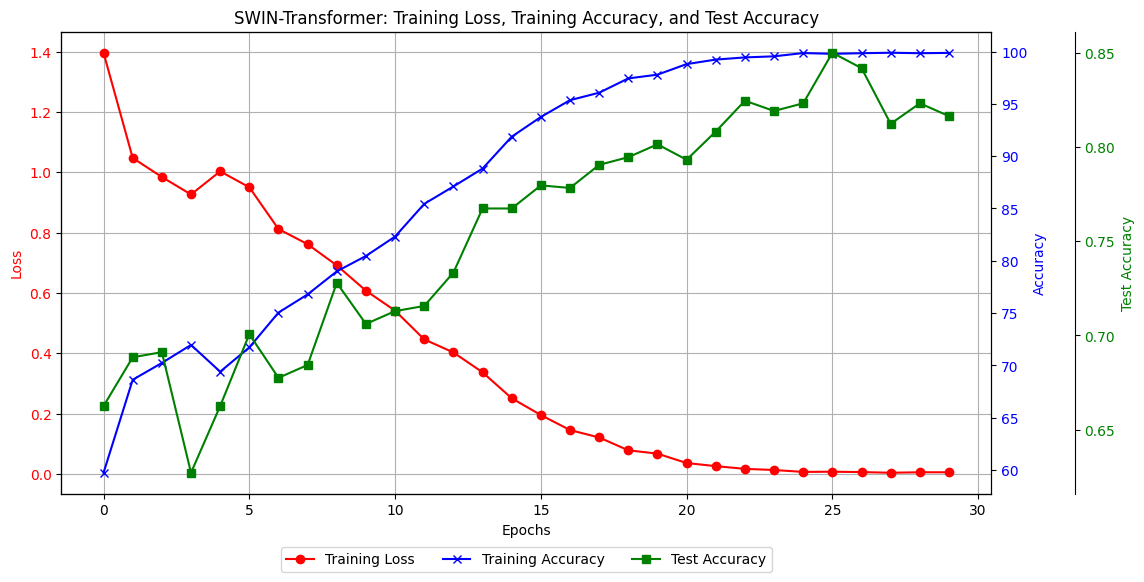

In [ ]:
# train_acc = [acc.item() for acc in train_accuracies]
# test_acc = [acc.item() for acc in test_acc_hist]

plot_metrics_acc(train_losses, train_accuracies, test_acc)

# Save logs

In [ ]:
LOG_FILE = '/content/drive/MyDrive/cs444-final-project/project/models/baselines/train_logs/ablation_swin_transformer.log'


In [ ]:
import json

data = {
    "train_loss": train_losses,
    "train_accuracy": train_accuracies,
    "train_gap": train_gap,
    "test_accuracy": test_acc
}
LOG_FILE
with open(LOG_FILE, "w") as json_file:
    json.dump(data, json_file, indent=4)


In [ ]:
# prompt: I have a json file called "ablation_swin_transformer.json" which contains four arrays: train_loss, train_accuracy, train_gap, and test_accuracy. I want you to read the json into the four python lists.

import json

with open("/content/drive/MyDrive/cs444-final-project/project/models/baselines/train_logs/ablation_swin_transformer.json", "r") as json_file:
    data = json.load(json_file)

train_losses = data["train_loss"]
train_accuracies = data["train_accuracy"]
train_gap = data["train_gap"]
test_acc = data["test_accuracy"]

